# The Perceptron

## Abstract

This blog post aims to investigate the function of the perceptron algorithm by performing various experiments with it. These experiments includes tests of the algorithm on linearly separable and inseparable data and data with dimensions greater than 2. These tests will show how the algorithm functions of different data, graphing the perceptron's loss and decision boundaries over time. Then, the algorithm will be tested for performance with minibatching, examining loss convergance at different batch sizes.

### Perceptron Code Link:

https://github.com/jblake05/jblake05.github.io/blob/main/posts/perceptron-post/perceptron.py

### Perceptron Grad Function:

My perceptron class has two implementations of the grad function, one with minibatching and one without. The grad function $1[s_iy_i < 0]y_ix_i$ is implemented by first calculating $s_i$ as $\langle w_i, x_i\rangle$ using torch.inner. Then I cast the expression $s_iy_i < 0$ to a boolean by multiplying it by 1. Finally I multiplied that expression by y_i and the vector x_i, flattening the expression to one dimension to add it to the weight. 

For the minibatching function grade_k, I implemented the equation $\frac{α}{k} \sum \limits _{l=1} ^{k} 1[\langle w, x_{i_k} \rangle y_{i_k} < 0]y_{i_k} x_{i_k}$ The score was formed the same way as the previous equation. The boolean map and y vector are resized from size n to size (n, 1) using y[:, None] to allow for multiplication with X. This matrix is then summed along each column to create a tensor the same size as the weight. Finally, $\frac{α}{k}$ is multiplied by the tensor to complete the equation.

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from perceptron import Perceptron, PerceptronOptimizer
import torch
from matplotlib import pyplot as plt

To test the perceptron, I first generated data to test using code from the perceptron lecture. Also using code from the lecture, I plotted the data, differentiating the groups of X (i.e. if they corrolate with y = 1 or -1) by color.

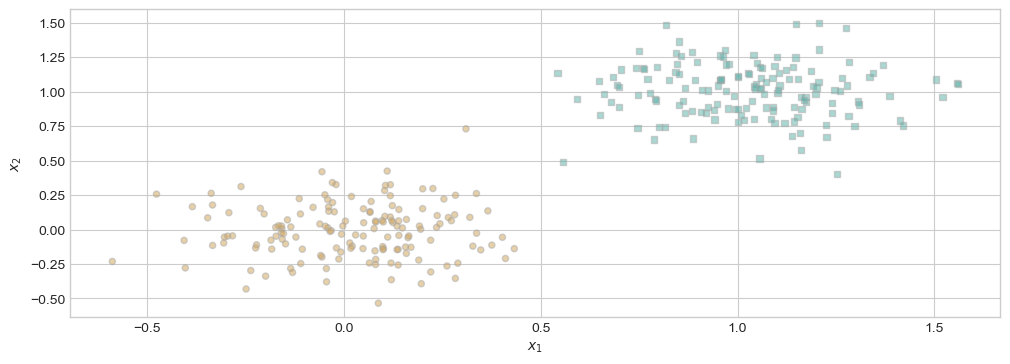

In [29]:
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

To test my perceptron, I ran the minimal training loop provided in the perceptron lecture. In doing so, I generate random values of X and y to act as inputs for the perceptron's optimizer. I also collect a vector of all unique (i.e. different from the previous) loss values, which are graphed below.

In [30]:
torch.manual_seed(130)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    if loss == 0:
        break
    
    # not part of the update: just for tracking our progress    
    prev_loss = loss

    loss = p.loss(X, y) 
    if (prev_loss != loss):
        loss_vec.append(loss)

    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

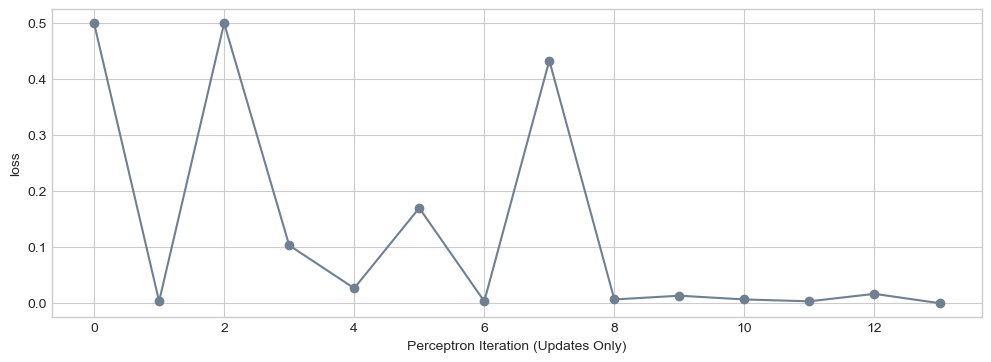

In [31]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Here, we see that the perceptron's loss converges to 0 on linearly separable data. Due to the randomly indexed data, the loss does not decrease monotonically, but trends lower over time.

Similar to the previous test, this experiment tests the perceptron's performance on a 2D dataset that is linearly separable. Instead of just plotting the loss, this code uses the draw_line function to show the decision boundary change over time relative to the dataset.

In [32]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

Like the last experiment, this block of code keeps track of the loss over time, graphing the dataset, x_i, and decision boundary at each step.

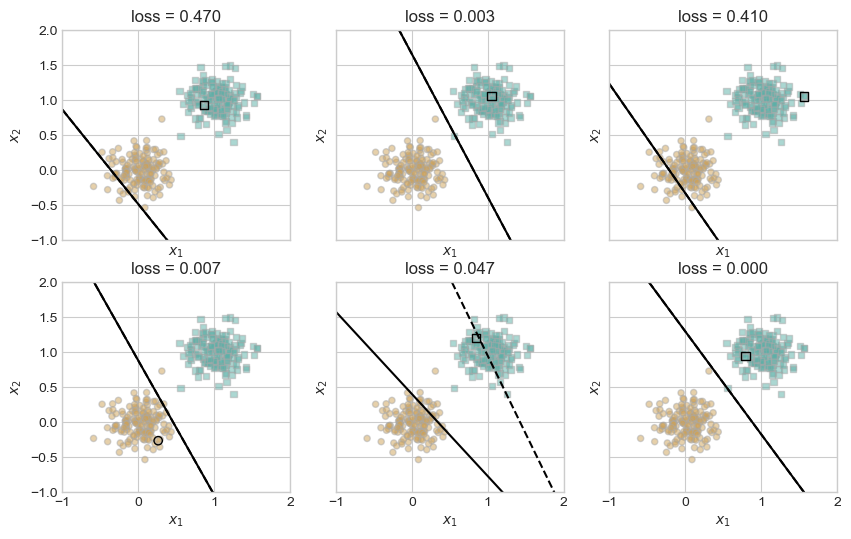

In [33]:
# adapted from lecture 7 (Perceptron)
torch.manual_seed(3619)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

# set up the figure
plt.rcParams["figure.figsize"] = (10, 6)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0: # dangerous -- only terminates if data is linearly separable
    ax = axarr.ravel()[current_ax]

    if loss == 0:
        break
    
    # not part of the update: just for tracking our progress    
    prev_loss = loss

    loss = p.loss(X, y) 

    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]

    old_w = torch.tensor([0, 0]) if p.w == None else torch.clone(p.w)
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)


    if (prev_loss != loss):
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1

This data shows the decision boundary improve over time, though not consistently (see the jump in loss between the second and third plots). Eventually, the loss converges on zero, plotting the decision boundary directly between the two groups.

To test the perceptron's behavior on linearly inseparable data, I create new data that has a higher amount of noise. This will result in data that doesn't have as clear groups, with outliers from one group that appear to be in the other group based on their values.

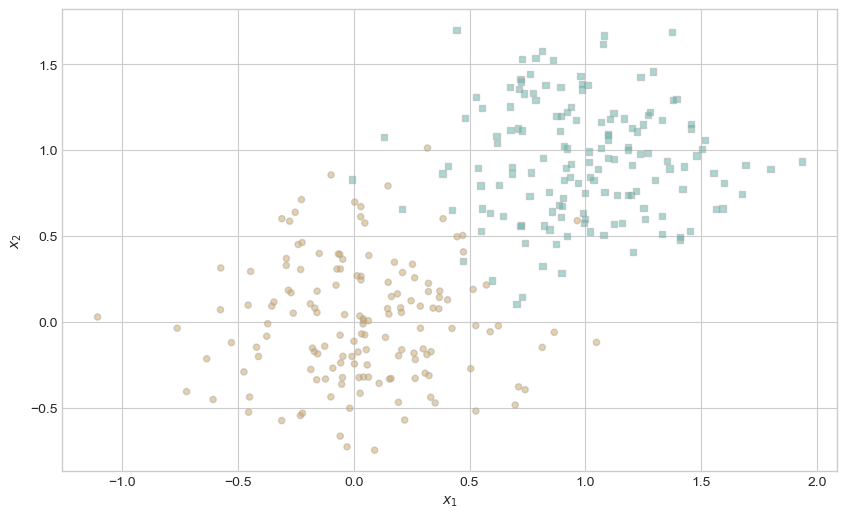

In [34]:
X2, y2 = perceptron_data(noise = 0.35)

fig, ax = plt.subplots(1, 1)
plot_perceptron_data(X2, y2, ax)

Here, we graph the decision boundary over time in a similar way to the linearly separable experiment. Since the data is linearly inseparable, though, the perceptron cannot achieve a loss of 0. As such, using the same function would result in an infinite loop and thus needs to break after a certain amount of iterations (here I chose 1000). For better visibility, only the first and last loss changes' decision boundaries were plotted. The number of iterations the plot was created at are included in the plot's label.

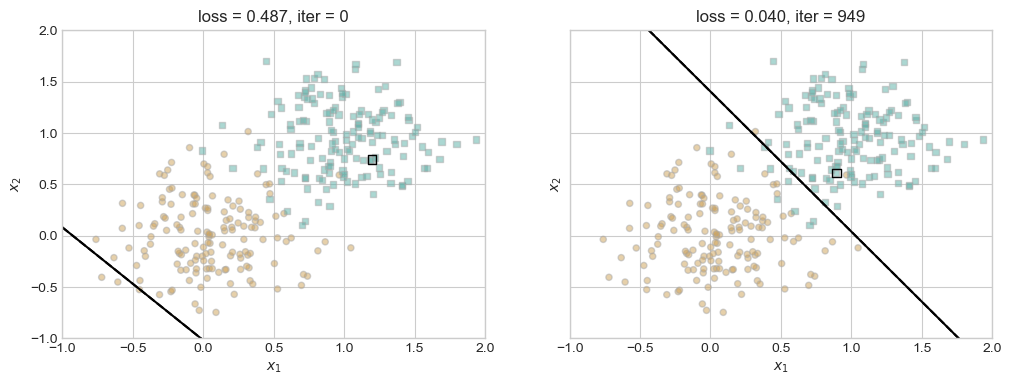

In [35]:
# adapted from lecture 7 (Perceptron)
torch.manual_seed(634)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X2.size()[0]

# set up the figure
plt.rcParams["figure.figsize"] = (12, 4)
fig, axarr = plt.subplots(1, 2, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

iter = 0
max_steps = 1000

while loss > 0: # dangerous -- only terminates if data is linearly separable
    if (iter == max_steps):
        break

    ax = axarr.ravel()[current_ax]

    if loss == 0:
        break
    
    # not part of the update: just for tracking our progress    
    prev_loss = loss

    loss = p.loss(X2, y2) 

    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X2[[i],:]
    y_i = y2[i]

    old_w = torch.tensor([0, 0]) if p.w == None else torch.clone(p.w)
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

    if (prev_loss != loss):
        loss = p.loss(X2, y2).item()
        loss_vec.append(loss)
        
        if iter == 0 or iter == 949:
            plot_perceptron_data(X2, y2, ax)
            draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
            draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
            
            ax.scatter(X2[i,0],X2[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
            ax.set_title(f"loss = {loss:.3f}, iter = {iter}")
            ax.set(xlim = (-1, 2), ylim = (-1, 2))
            
            if iter == 0:
                current_ax += 1
    
    iter += 1

Here we can see that, although the data is linearly inseparable, the loss still decreases immensely over the course of 1000 iterations. The decision boundary, then, gets much closer to separating the data over time. The loss can be seen more clearly by plotting its values over time.

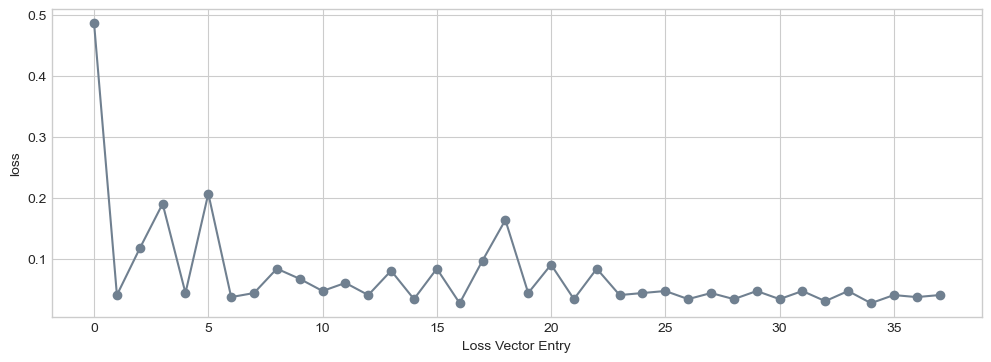

In [36]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Loss Vector Entry", ylabel = "loss")

Again, the loss values decrease over time, but not steadily. Instead of decreasing to 0, of course, the loss stays around 0 without converging to it. 

For the final experiment on non-minibatch data, I tested the perceptron's results on data with more than 2 dimensions. To test the progress of the experiment, I kept track of the loss values over time and printed them out at the end of the loop.

In [37]:
X3, y3 = perceptron_data(p_dims = 5)

p = Perceptron()
opt = PerceptronOptimizer(p)

loss = 1.0
loss_vec = []

step = 0
max_steps = 10000

while loss > 0:
    if step == max_steps:
        break

    prev_loss = loss

    loss = p.loss(X3, y3) 

    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X3[[i],:]
    y_i = y3[i]

    opt.step(x_i, y_i)

    if prev_loss != loss:
        loss = p.loss(X3, y3).item()
        loss_vec.append(loss)
    step += 1

print(loss_vec, step)

[0.25333333015441895, 0.23333333432674408, 0.2566666603088379, 0.009999999776482582, 0.0] 46


This shows that the perceptron can converge on 5-dimensional data that is linearly separable. As the printed loss vector shows, the perceptron's loss converges to 0 in 5 changes of loss over the course of 46 steps. As such, the model correctly predicts data at 100% accuracy for the training data.

Next, I set up a graphing function for testing perceptron minibatching. Again, this function is similar to the other decision graphing functions above. Instead of randomly choosing one index for the data, however, the function chooses a set of indices using torch's randperm function. This function also uses my perceptron's step_k and grad_k functions to test the minibatch on batches of size k. For reference, the grad_k implementation was described at the top of this post.

In [52]:
def graph_k(X, y, k, alpha, rows=5, cols=5, xdim=10, ydim=6, seed=3619):
    # adapted from lecture 7 (Perceptron)
    torch.manual_seed(seed)

    # instantiate a model and an optimizer
    p = Perceptron() 
    opt = PerceptronOptimizer(p)

    loss = 1.0

    # for keeping track of loss values
    loss_vec = []

    n = X.size()[0]

    # set up the figure
    plt.rcParams["figure.figsize"] = (xdim, ydim)
    fig, axarr = plt.subplots(rows, cols, sharex = True, sharey = True)
    markers = ["o", ","]
    marker_map = {-1 : 0, 1 : 1}

    # initialize for main loop
    current_ax = 0
    loss = 1
    loss_vec = []
    iter =  0

    while loss > 0: # dangerous -- only terminates if data is linearly separable
        ax = axarr.ravel()[current_ax]

        if loss == 0:
            break
        
        # not part of the update: just for tracking our progress    
        prev_loss = loss

        loss = p.loss(X, y) 

        # pick a random data point
        ix = torch.randperm(X.size(0))[:k]
        x_i = X[ix,:]
        y_i = y[ix]

        old_w = torch.tensor([0, 0]) if p.w == None else torch.clone(p.w)
        
        # perform a perceptron update using the random data point
        opt.step_k(x_i, y_i, alpha, k)

        if (prev_loss != loss):
            plot_perceptron_data(X, y, ax)
            draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
            loss = p.loss(X, y).item()
            loss_vec.append(loss)
            draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
            # try ix instead of i here
            ax.scatter(X[ix,0],X[ix,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
            # draw_line(w, -10, 10, ax, color = "black")
            ax.set_title(f"loss = {loss:.3f}")
            ax.set(xlim = (-1, 2), ylim = (-1, 2))
            current_ax += 1
            iter += 1

First, I graphed the minibatch on a batch size of 1. This was done to test the performance of the batch gradient and step functions, particularly in comparison to the non-batched perceptron functions. As the graph shows, the perceptron finds the separating line between the two groups roughly as quickly as the original algorithm.

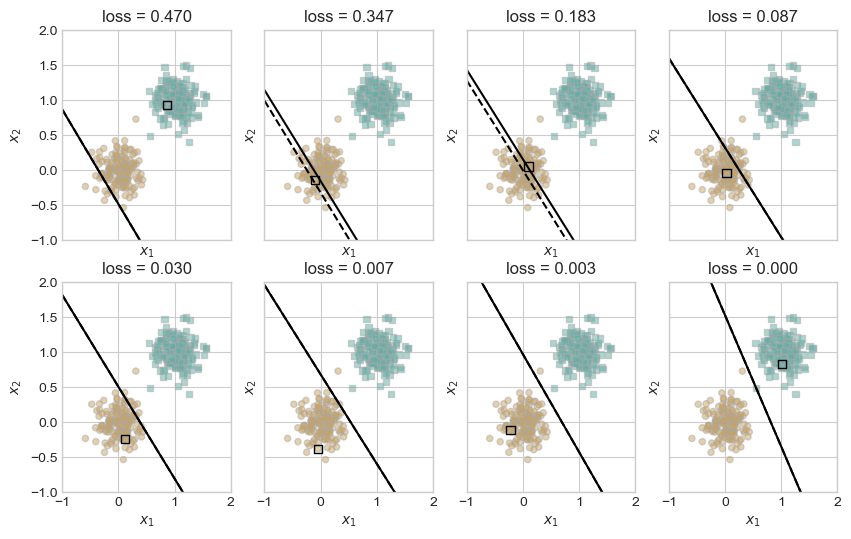

In [39]:
graph_k(X, y, 1, 0.1, 2, 4)

Second, this test shows that a minibatch with a batch size of 10 converges on a two-dimensional, linearly-seperable dataset given enough time. This test notably takes more time to converge than a perceptron with a batch size of 1.

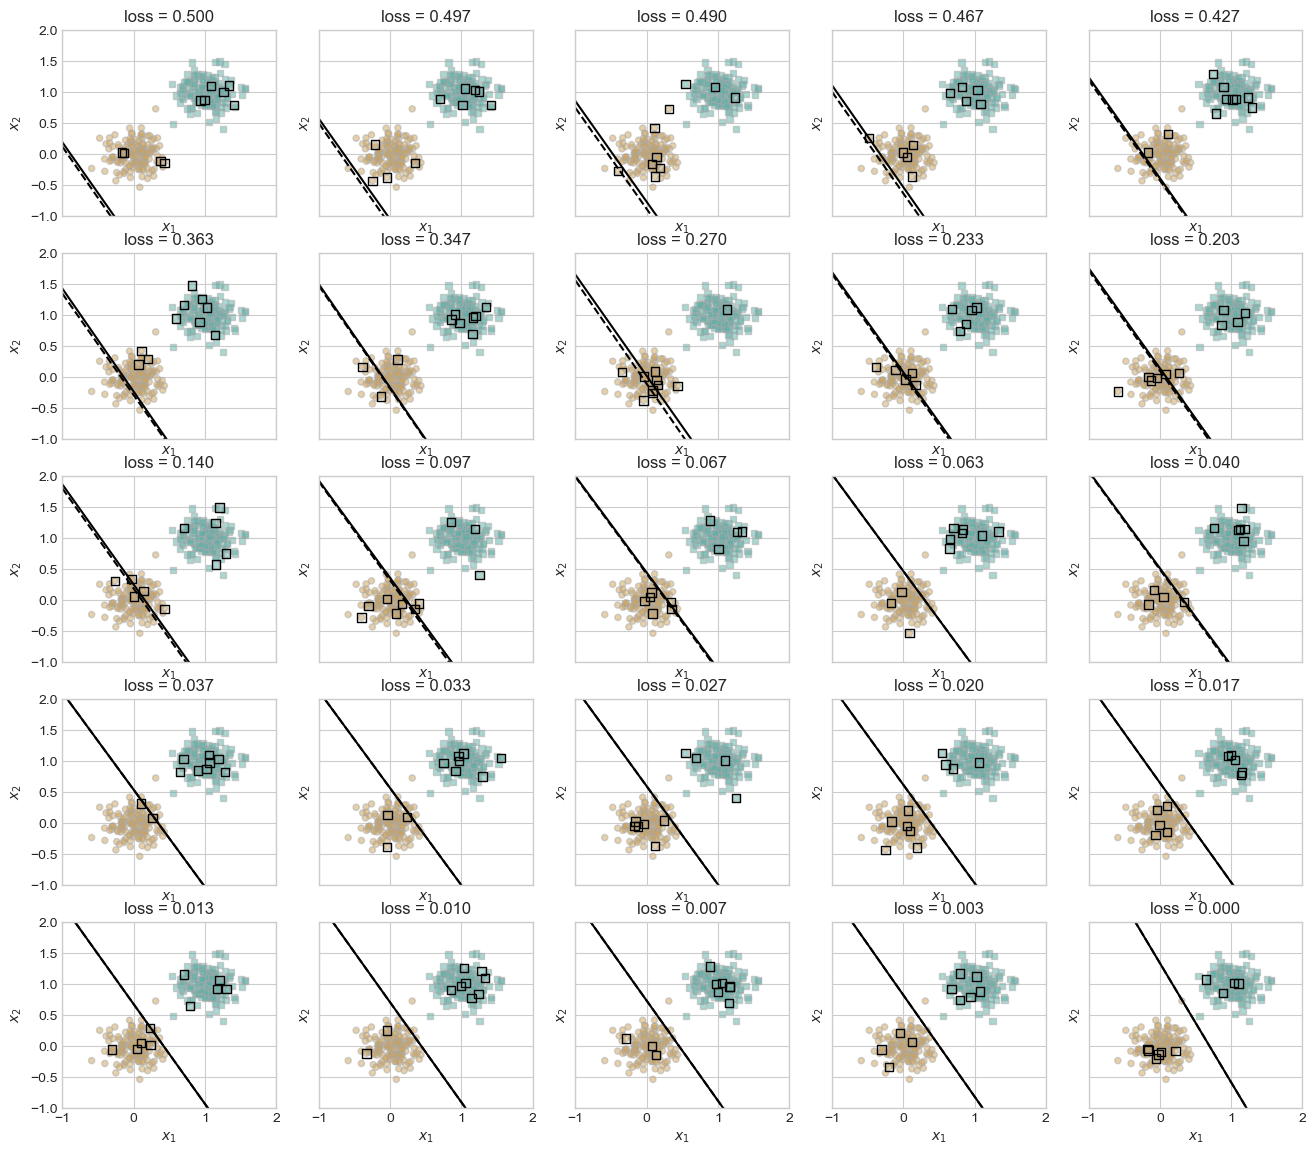

In [53]:
graph_k(X, y, 10, 0.1, rows=5, cols=5, xdim=16, ydim=14, seed=9000)

Finally, to test the minibatch performance on linearly inseparable data, I created a block of code that terminates after 10000 steps, calling opt.step_k() with a batch size of n (the size of the data). After running this code for 10000, the loss is plotted over time.

In [41]:
# adapted from lecture 7 (Perceptron)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

# for keeping track of loss values
loss_vec = []

n = X2.size()[0]

# initialize for main loop
loss = 1
loss_vec = []

max_steps = 10000
step = 0

k = X2.shape[0]
alpha = 0.01

while loss > 0: # dangerous -- only terminates if data is linearly separable
    if (step >= max_steps):
        break

    ax = axarr.ravel()[current_ax]

    if loss == 0:
        break
        
    # not part of the update: just for tracking our progress    
    prev_loss = loss

    loss = p.loss(X2, y2) 

    # pick a random data point
    # i = torch.randint(n, size = (1,))
    ix = torch.randperm(X2.size(0))[:k]
    x_i = X2[ix,:]
    y_i = y2[ix]

    old_w = torch.tensor([0, 0]) if p.w == None else torch.clone(p.w)
        
    # perform a perceptron update using the random data point
    opt.step_k(x_i, y_i, alpha, k)

    loss = p.loss(X2, y2).item()
    loss_vec.append(loss)
    step += 1

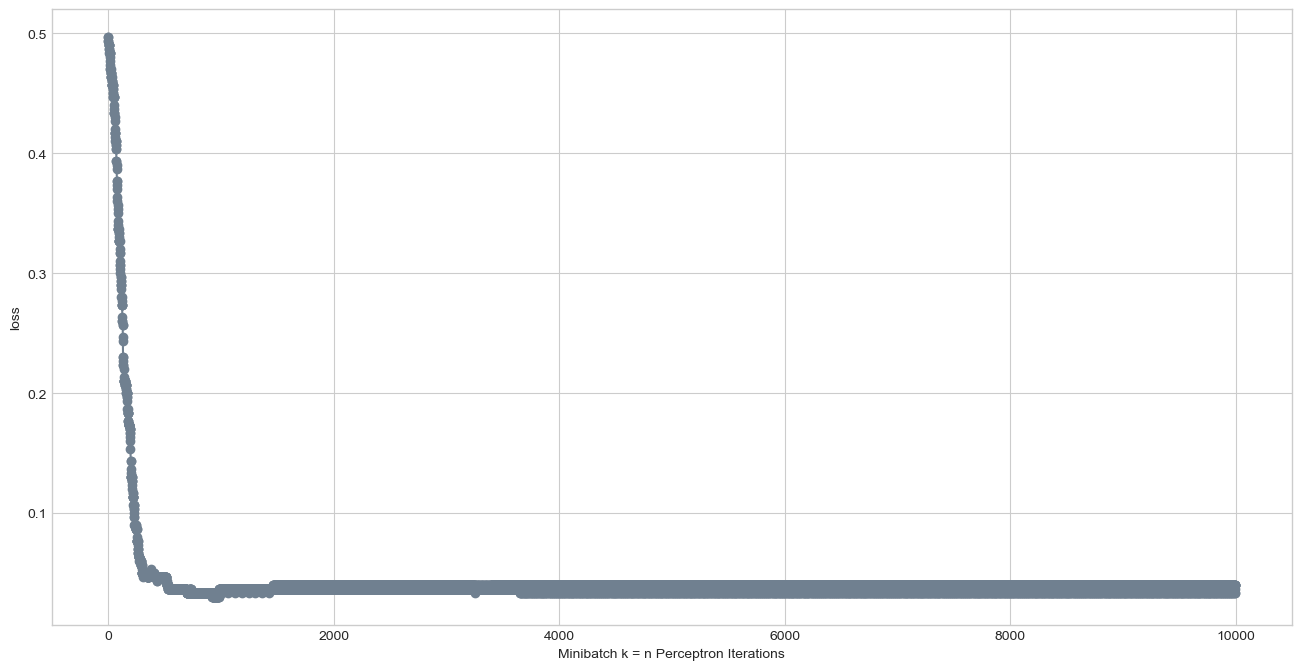

In [42]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Minibatch k = n Perceptron Iterations", ylabel = "loss")

In [45]:
loss_vec[len(loss_vec) - 1]

0.03999999910593033

While this test doesn't converge at 0, it does show that running the minibatch with a batchsize of n converges to a low loss value.

In [ ]:
loss = p.loss(X, y) # ====
# y_ = 2*y - 1 # O(n)
# (1.0*(self.score(X)*y_ < 0)).mean() ==== 
# 1 * torch.matmul(X, torch.t(self.w)) * y < 0 = O(n)

# pick a random data point
i = torch.randint(n, size = (1,)) # O(1)
x_i = X[[i],:] # O(1)
y_i = y[i] # O(1)

old_w = torch.tensor([0, 0]) if p.w == None else torch.clone(p.w) # O(1) OR O(p)
    
# perform a perceptron update using the random data point
opt.step(x_i, y_i) # grad could be O(p)

In [ ]:
loss = p.loss(X, y) # O(np)

# pick a random data point
ix = torch.randperm(X.size(0))[:k] #O(k)
x_i = X[ix,:] # O(k)
y_i = y[ix] # O(k)
        
# perform a perceptron update using the random data point
opt.step_k(x_i, y_i, alpha, k)

# self.model.loss(X, y) # for an X of dim k * p and a y of size k,
# this has a runtime of O(kp)
# self.model.w += self.model.grad_k(X, y, alpha, k)

# s_i = torch.inner(torch.t(self.w), X) # p * (k*p) = O(kp) results in size k*p
# return torch.sum(((1 * (s_i*y < 0))[:, None]*y[:, None]*X), axis=0)
# k*p*k * k * k * p

loss = p.loss(X, y).item() # O(np)

## Runtime Discussion

For the runtime of the perceptron, a single iteration without minibatching will have a runtime of O(n) if n > p and a runtime of O(p) if p > n. The O(n) appears in the loss calculation's matrix multiplication and the O(p) appears in the gradient calculation. In the minibatch implementation, the runtime is O(kp) (seen in the grad_k calculation step) if kp > n and O(n) (seen in the matrix multiplication) if n > kp.

## Conclusion

In the creation and testing of the perceptron algorithm, I found that -- while it seems to work well for linearly separable data -- it can be a bit awkward to run on linearly inseparable data. On two dimensional data, the perceptron converged to zero quickly for linearly separable data. While it isn't possible for this to occur on linearly inseparable data, it did progressively improve over time before plateauing before zero. This ability to achieve zero loss with linearly separable data holds at higher dimensions, as well. Similarly, I found that a minibatch perceptron could converge to zero on linearly separable data (though at slower rates than non-batched perceptrons at higher batch sizes) and to a low non-zero value on inseparable data with a large batch size.